# Modelo Predicción de Ocupación

## Contenido
* Parámetros generales e Importacion de biblioticas
* Carga de los datos
* Parámetros Generales
* Preprocesamiento
 * Unificación 
* Modelo
 * Procesamiento
 * Tidy Table
 * Separación Xvar y Yvar  (número variable de periodo)
 * Separacion Train y Test
 * Configuración de los Modelos
 * Funciones 
  * F. para evaluar varios modelos
  * F. para categorizar en semáforo
  * F. Evaluación de resultados Exactitud
* Generacion de Pronosticos a futuro
 * Procesamiento entrada para pronóstico
 * Ejecución del modelos y archivo de entrega

## Parámetros generales e Importacion de bibliotecas

In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from datetime import datetime
from dateutil.relativedelta import relativedelta
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix # es una manera para resumir los datos 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve #roc_curve
from sklearn.metrics import roc_auc_score #auc
from joblib import dump,load

## Carga de los datos

In [13]:
df_Nodosokla= pd.read_csv("../DatosOrigen/NODOS_INFO_OOKLA.csv",sep=';', header = 0)
data_ocupacionNodo = pd.read_csv('../DatosOrigen/OCUPACION_NODO.csv', sep=';')
data_NodoINFI = pd.read_csv('../DatosOrigen/NODO_INFI.csv', sep=';')
data_SEG = pd.read_csv('../DatosOrigen/segmentacion.csv', sep=';') 

### Base OOKLA

In [4]:
df_Nodosokla['DIA']=1 # le agrego la columna dia
df_Nodosokla['MES'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['MES']]
df_Nodosokla['DIA'] = [f'0{x}' if x <10 else str(x) for x in df_Nodosokla['DIA']]
df_Nodosokla['FECHA'] = df_Nodosokla['ANIO'].astype('str') + '-' + df_Nodosokla['MES'] + '-' + df_Nodosokla['DIA']
# eliminamos columnas cobrantes
df_Nodosokla=df_Nodosokla.drop(['DIA','MES','ANIO'], axis=1)
# ordenamos
df_Nodosokla = df_Nodosokla[['NODO','FECHA', 'OPERADOR','CANTIDAD','DOWNLOAD_KBPS','UPLOAD_KBPS','LATENCY','FLAG_LAT']] 
# # renombramos columnas
df_Nodosokla.rename(columns={'NODO':'COD_NODO'}, inplace=True)
df_Nodosokla_Claro=df_Nodosokla[df_Nodosokla["OPERADOR"]=="CLARO"]
del(df_Nodosokla_Claro['OPERADOR'])

### Base data_NodoINF

In [5]:
data_NodoINFI['DIA']=1 # le agrego la columna dia
data_NodoINFI['MES'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['MES']]
data_NodoINFI['DIA'] = [f'0{x}' if x <10 else str(x) for x in data_NodoINFI['DIA']]
data_NodoINFI['FECHA'] = (2000+data_NodoINFI['ANIO']).astype('str') + '-' + data_NodoINFI['MES'] + '-' + data_NodoINFI['DIA']
# eliminamos columnas sobrantes
data_NodoINFI=data_NodoINFI.drop(['DIA','MES','ANIO'], axis=1)
# # renombramos columnas
data_NodoINFI.rename(columns={'NODO':'COD_NODO'}, inplace=True)
### completar Nullos con 0
data_NodoINFI=data_NodoINFI.fillna(0)

### Base data_NodoINF data_SEG

In [6]:
data_SEG.drop(['NUEVA ESTRUCTURA'], axis=1,inplace=True)
data_SEG['SEGMENTADO']=1

## Preprocesamiento
### Unificacion

In [7]:
data_ocupacion=pd.merge(data_ocupacionNodo, data_NodoINFI, on = ('COD_NODO','FECHA'), how='left')
data_ocupacion=pd.merge(data_ocupacion, data_SEG, on = ('COD_NODO','FECHA'), how='left')

### Parámetros generales

In [9]:
start = datetime.now()

In [10]:
fechaMaxima=datetime.strptime(data_ocupacion['FECHA'].max(),'%Y-%m-%d')
periodos_y=7
periodos_x=7
variable_prediccion='OCUPACION_DW'

In [11]:
fechaLimite=fechaMaxima + relativedelta(months=-1*periodos_y)
fechaInicial=fechaLimite + relativedelta(months=-1*periodos_x)

### Selección Fechas

In [12]:
## Eliminar informaición anterior Junion 2022
data_ocupacion['FECHA']=data_ocupacion['FECHA'].astype('datetime64[ns]')
### Elininar datos últimos mes
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']>=fechaInicial]
### Eliminar Fecha Final  (mes incompleto)
data_ocupacion=data_ocupacion[data_ocupacion['FECHA']<fechaMaxima]

##  Funciones

In [13]:
#Funcion para Calcular el número de periodos hacia atrás
def diff_month(d1, d2):
    return (d1.year - d2.dt.year) * 12 + d1.month - d2.dt.month

In [14]:
def semaforo(df, col):
    df = df.copy()
    df.loc[(df[col]>=0.58) & (df[col]<=0.75), 'ESTATUS'] = 'AMARILLO'
    df.loc[df[col]>0.75, 'ESTATUS'] = 'ROJO'
    df.loc[df[col]<0.60, 'ESTATUS'] = 'VERDE'
    return(df)

In [15]:
def semaforoVal(val):
    #df = df.copy()
    respuesta='V'
    if (val>=0.58) & (val<=0.75):
        respuesta='A'
    elif val>0.75:
        respuesta='R'
    return(respuesta)

In [16]:
def semaforoNum2Val(val):   
    respuesta='V'
    if val==1:
        respuesta='A'
    elif val==2:
        respuesta='R'
    return(respuesta)

In [17]:
def semaforoVal2Num(val):   
    respuesta=0
    if val=='A':
        respuesta=1
    elif val=='R':
        respuesta=2
    return(respuesta)

In [18]:
def semaforoRojo(val):    
    if val>0.75:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [19]:
def semaforoAmarillo(val):    
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [20]:
def semaforoRojoAmarillo(val):    
    if val>=0.58:
        respuesta=1
    else :
        respuesta=0
    return(respuesta)

In [21]:
def semaforoNum(val):
    #df = df.copy()
    respuesta=0
    if (val>=0.58) & (val<=0.75):
        respuesta=1
    elif val>0.75:
        respuesta=2
    return(respuesta)

In [22]:
def semaforoNum2Rojo(val):    
    respuesta=0
    if val==2:
        respuesta=1    
    return(respuesta)

In [23]:
def semaforoNum2Amarillo(val):    
    respuesta=0
    if val==1:
        respuesta=1    
    return(respuesta)

In [24]:
def semaforoNum2RojoAmarillo(val):    
    respuesta=0
    if val>=1:
        respuesta=1    
    return(respuesta)

In [25]:
def medidasEvaluacion(matrizConfucion):
    exactitud=np.trace(matrizConfucion)/matrizConfucion.sum()
    print ('exactitud:', exactitud)
    sensibilidad=[0]*3
    especificidad=[0]*3
    for i in range(0,len(matrizConfucion)):
        sensibilidad[i]=matrizConfucion[i,i]/matrizConfucion.sum(axis=1)[i]
        especificidad[i]=np.delete(np.delete(matrizConfucion,i, axis=0),i,axis=1).sum()/np.delete(matrizConfucion,i, axis=0).sum()
        print ('sensibilidad ',i,": ",sensibilidad[i])
        print ('especificidad ',i,": ",especificidad[i])

In [26]:
def sampling_strategy(X,y,n_samples,t='majority'):
    target_classes=''
    if t== 'majority':
        target_classes= y.value_counts() >n_samples
    elif t== 'minority':
        target_classes = y.value_counts() < n_samples
    tc=target_classes[target_classes ==True].index
    #target_classes_all=y.value_counts().index
    sampling_strategy={}
    for target in tc:
        sampling_strategy[target]= n_samples
    return sampling_strategy

In [27]:
def df2Feature_importanceClass(x_train_b,mod,title):
    #shap_test = x_train_b.sample(1000)
    shap_test = x_train_b
    shap_values = shap.TreeExplainer(mod).shap_values(shap_test)
    plt.figure()
    plt.title(title)
    shap.summary_plot(shap_values, shap_test,max_display=30)
    plt.subplots_adjust(left=0.35, right=0.9, top=0.9, bottom=0.3)    
    plt.show();

## Modelo
### Procesamiento

In [28]:
data_ocupacion['mesAnt']=(periodos_x+periodos_y)-diff_month(fechaMaxima,data_ocupacion['FECHA'])
### Ordenar por fecha
data_ocupacion=data_ocupacion.sort_values(["FECHA","COD_NODO"], ascending = (True, True))

### Seleccion Nodos para el Modelo

In [29]:
### Solo Nodos con información completa
seleccion=data_ocupacion[['COD_NODO',variable_prediccion]].groupby('COD_NODO').count()
seleccion[seleccion[variable_prediccion]>=periodos_y+periodos_x+1]
seleccion.rename(columns={variable_prediccion:'noRegVarPre'}, inplace=True)
data_ocupacion=data_ocupacion.merge(seleccion, on='COD_NODO', how='left')
data_ocupacion=data_ocupacion[data_ocupacion['noRegVarPre']>=periodos_y+periodos_x]
data_ocupacion.drop(columns='noRegVarPre', inplace=True)
### Nodos No Segmentados en el periodo de tiempo considerado
data_ocupacion=data_ocupacion[data_ocupacion['SEGMENTADO']!=1]
data_ocupacion.drop(columns='SEGMENTADO', inplace=True)
### Eliminar datos con nullos
data_ocupacion=data_ocupacion.dropna()

###  Selección Columnas

In [30]:
selCols=['COD_NODO','FECHA','OCUPACION_DW','OCUPACION_UP','SERV_INT','mesAnt']
data_ocupacionC=data_ocupacion.copy()
data_ocupacion=data_ocupacion[selCols]

### Tidy Tables

#### Regresión

In [31]:
cols=data_ocupacion.columns
cols=cols[2:-1]

In [32]:
cols_x=[]
for i, col in enumerate(cols):
    tablaAnalisis = pd.pivot_table(data_ocupacion.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_x=cols_x+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotal = tablaAnalisis
    else:
        tablaAnalisisTotal = tablaAnalisisTotal.merge(tablaAnalisis, how='outer', on='COD_NODO')

In [33]:
cols_x=sorted(list(set(cols_x)& set(tablaAnalisisTotal.columns.tolist())))

In [34]:
cols_y=[(variable_prediccion+"-"+str(x)) for x in range(periodos_x,periodos_x+periodos_y-1)]

In [35]:
tablaAnalisisTotal=tablaAnalisisTotal.dropna()

In [36]:
data_ocupacionC.head()

,COD_NODO,FECHA,OCUPACION_DW,OCUPACION_UP,CANT_USER,PROM_VEL,MEDIANA_VEL,VEL_ME_8,VEL_10_25,VEL_30,...,VEL_MAX,VEL_MIN,RENTA,PROM_RENTA,CONVERGENTE,SERV_INT,SERV_TV,SERV_VOZ,CANT_CALL,mesAnt
0,01J,2020-06-01,0.263806,0.181200,24.0,41.0,30.0,3.0,3.0,9.0,...,100.0,5.0,2598062.0,108253.0,3.0,24.0,19.0,16.0,0.0,0
1,01S,2020-06-01,0.195382,0.180599,77.0,37.0,30.0,16.0,7.0,23.0,...,150.0,5.0,7494860.0,97336.0,45.0,77.0,58.0,64.0,10.0,0
3,02J,2020-06-01,0.263806,0.181200,14.0,43.0,30.0,0.0,5.0,3.0,...,150.0,10.0,1880516.0,134323.0,6.0,14.0,11.0,13.0,0.0,0
4,02S,2020-06-01,0.195382,0.145466,61.0,28.0,30.0,12.0,13.0,18.0,...,100.0,5.0,5881685.0,96421.0,22.0,61.0,51.0,54.0,5.0,0
5,03J,2020-06-01,0.263806,0.181200,26.0,30.0,30.0,2.0,8.0,7.0,...,75.0,3.0,2983096.0,114734.0,9.0,26.0,25.0,23.0,2.0,0


#### Clasificación

In [37]:
colsC=data_ocupacionC.columns
colsC=colsC[2:-1]

In [38]:
cols_xC=[]
for i, col in enumerate(colsC):
    tablaAnalisis = pd.pivot_table(data_ocupacionC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisis.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisis.columns}, inplace=True)
    #Identificacion Columnas X y Y    
    cols_xC=cols_xC+[(col+"-"+str(x)) for x in range(0,periodos_x)]    
    if i==0:
        tablaAnalisisTotalC = tablaAnalisis
    else:
        tablaAnalisisTotalC = tablaAnalisisTotalC.merge(tablaAnalisis, how='outer', on='COD_NODO')
tablaAnalisisTotalC=tablaAnalisisTotalC.dropna()

In [39]:
cols_xC=sorted(list(set(cols_xC)& set(tablaAnalisisTotalC.columns.tolist())))

### Separación Xvar y Yvar (número variable de periodo)

In [40]:
Xvar=tablaAnalisisTotal[cols_x]
XvarC=tablaAnalisisTotalC[cols_xC]
yvar=tablaAnalisisTotal[cols_y]

In [41]:
for col in cols_y:    
    yvar[col+'_sem']=yvar[col].apply(semaforoRojo)
    yvar[col+'_sem2']=yvar[col].apply(semaforoNum)    

yColClass=[s + '_sem2' for s in cols_y]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Separacion Train y Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(Xvar, yvar, test_size = 0.3, random_state = 86, shuffle= True)

##  Modelos ML

### XGBRegressor

In [43]:
modelos={}
for yCol in cols_y:
    print(yCol)
    y_train_aux=y_train[yCol]
    y_test_aux=y_test[yCol]
    dicModelo={}        
    dicModelo['modelo']=xgb.XGBRegressor(max_depth=80, verbosity= 0, subsample=0.5,  n_estimators=472, n_jobs=-1, objective='reg:squarederror', booster='gbtree', random_state=42, learning_rate=0.04, reg_lambda=1)
    dicModelo['modelo'].fit(X_train, y_train_aux, eval_set=[(X_train, y_train_aux), (X_test, y_test_aux)])
    dicModelo['predictions'] = dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])    
    modelos[yCol]=dicModelo    

OCUPACION_DW-7
[0]	validation_0-rmse:0.18240	validation_1-rmse:0.17944
[1]	validation_0-rmse:0.17543	validation_1-rmse:0.17263
[2]	validation_0-rmse:0.16874	validation_1-rmse:0.16607
[3]	validation_0-rmse:0.16231	validation_1-rmse:0.15980
[4]	validation_0-rmse:0.15614	validation_1-rmse:0.15376
[5]	validation_0-rmse:0.15024	validation_1-rmse:0.14800
[6]	validation_0-rmse:0.14461	validation_1-rmse:0.14250
[7]	validation_0-rmse:0.13919	validation_1-rmse:0.13724
[8]	validation_0-rmse:0.13399	validation_1-rmse:0.13220
[9]	validation_0-rmse:0.12898	validation_1-rmse:0.12733
[10]	validation_0-rmse:0.12415	validation_1-rmse:0.12265
[11]	validation_0-rmse:0.11953	validation_1-rmse:0.11819
[12]	validation_0-rmse:0.11510	validation_1-rmse:0.11392
[13]	validation_0-rmse:0.11086	validation_1-rmse:0.10985
[14]	validation_0-rmse:0.10678	validation_1-rmse:0.10591
[15]	validation_0-rmse:0.10288	validation_1-rmse:0.10215
[16]	validation_0-rmse:0.09916	validation_1-rmse:0.09856
[17]	validation_0-rmse:0.0

[143]	validation_0-rmse:0.00649	validation_1-rmse:0.02771
[144]	validation_0-rmse:0.00641	validation_1-rmse:0.02770
[145]	validation_0-rmse:0.00634	validation_1-rmse:0.02769
[146]	validation_0-rmse:0.00627	validation_1-rmse:0.02769
[147]	validation_0-rmse:0.00619	validation_1-rmse:0.02768
[148]	validation_0-rmse:0.00611	validation_1-rmse:0.02767
[149]	validation_0-rmse:0.00604	validation_1-rmse:0.02765
[150]	validation_0-rmse:0.00597	validation_1-rmse:0.02764
[151]	validation_0-rmse:0.00590	validation_1-rmse:0.02764
[152]	validation_0-rmse:0.00582	validation_1-rmse:0.02764
[153]	validation_0-rmse:0.00576	validation_1-rmse:0.02763
[154]	validation_0-rmse:0.00571	validation_1-rmse:0.02762
[155]	validation_0-rmse:0.00565	validation_1-rmse:0.02761
[156]	validation_0-rmse:0.00559	validation_1-rmse:0.02761
[157]	validation_0-rmse:0.00552	validation_1-rmse:0.02759
[158]	validation_0-rmse:0.00545	validation_1-rmse:0.02759
[159]	validation_0-rmse:0.00540	validation_1-rmse:0.02757
[160]	validati

[285]	validation_0-rmse:0.00151	validation_1-rmse:0.02722
[286]	validation_0-rmse:0.00150	validation_1-rmse:0.02722
[287]	validation_0-rmse:0.00149	validation_1-rmse:0.02721
[288]	validation_0-rmse:0.00147	validation_1-rmse:0.02721
[289]	validation_0-rmse:0.00145	validation_1-rmse:0.02721
[290]	validation_0-rmse:0.00144	validation_1-rmse:0.02721
[291]	validation_0-rmse:0.00143	validation_1-rmse:0.02721
[292]	validation_0-rmse:0.00142	validation_1-rmse:0.02721
[293]	validation_0-rmse:0.00141	validation_1-rmse:0.02721
[294]	validation_0-rmse:0.00139	validation_1-rmse:0.02721
[295]	validation_0-rmse:0.00138	validation_1-rmse:0.02721
[296]	validation_0-rmse:0.00137	validation_1-rmse:0.02721
[297]	validation_0-rmse:0.00136	validation_1-rmse:0.02721
[298]	validation_0-rmse:0.00135	validation_1-rmse:0.02720
[299]	validation_0-rmse:0.00133	validation_1-rmse:0.02721
[300]	validation_0-rmse:0.00132	validation_1-rmse:0.02720
[301]	validation_0-rmse:0.00131	validation_1-rmse:0.02720
[302]	validati

[97]	validation_0-rmse:0.01324	validation_1-rmse:0.03216
[98]	validation_0-rmse:0.01305	validation_1-rmse:0.03212
[99]	validation_0-rmse:0.01287	validation_1-rmse:0.03209
[100]	validation_0-rmse:0.01267	validation_1-rmse:0.03203
[101]	validation_0-rmse:0.01249	validation_1-rmse:0.03199
[102]	validation_0-rmse:0.01232	validation_1-rmse:0.03197
[103]	validation_0-rmse:0.01216	validation_1-rmse:0.03193
[104]	validation_0-rmse:0.01198	validation_1-rmse:0.03189
[105]	validation_0-rmse:0.01182	validation_1-rmse:0.03186
[106]	validation_0-rmse:0.01167	validation_1-rmse:0.03183
[107]	validation_0-rmse:0.01151	validation_1-rmse:0.03180
[108]	validation_0-rmse:0.01134	validation_1-rmse:0.03176
[109]	validation_0-rmse:0.01119	validation_1-rmse:0.03172
[110]	validation_0-rmse:0.01103	validation_1-rmse:0.03170
[111]	validation_0-rmse:0.01088	validation_1-rmse:0.03167
[112]	validation_0-rmse:0.01075	validation_1-rmse:0.03163
[113]	validation_0-rmse:0.01061	validation_1-rmse:0.03162
[114]	validation_

[239]	validation_0-rmse:0.00270	validation_1-rmse:0.03061
[240]	validation_0-rmse:0.00267	validation_1-rmse:0.03061
[241]	validation_0-rmse:0.00264	validation_1-rmse:0.03061
[242]	validation_0-rmse:0.00261	validation_1-rmse:0.03061
[243]	validation_0-rmse:0.00259	validation_1-rmse:0.03061
[244]	validation_0-rmse:0.00257	validation_1-rmse:0.03061
[245]	validation_0-rmse:0.00254	validation_1-rmse:0.03060
[246]	validation_0-rmse:0.00251	validation_1-rmse:0.03060
[247]	validation_0-rmse:0.00249	validation_1-rmse:0.03060
[248]	validation_0-rmse:0.00246	validation_1-rmse:0.03060
[249]	validation_0-rmse:0.00244	validation_1-rmse:0.03060
[250]	validation_0-rmse:0.00241	validation_1-rmse:0.03060
[251]	validation_0-rmse:0.00239	validation_1-rmse:0.03059
[252]	validation_0-rmse:0.00237	validation_1-rmse:0.03059
[253]	validation_0-rmse:0.00234	validation_1-rmse:0.03059
[254]	validation_0-rmse:0.00232	validation_1-rmse:0.03059
[255]	validation_0-rmse:0.00230	validation_1-rmse:0.03059
[256]	validati

[381]	validation_0-rmse:0.00084	validation_1-rmse:0.03052
[382]	validation_0-rmse:0.00083	validation_1-rmse:0.03052
[383]	validation_0-rmse:0.00083	validation_1-rmse:0.03052
[384]	validation_0-rmse:0.00082	validation_1-rmse:0.03052
[385]	validation_0-rmse:0.00082	validation_1-rmse:0.03052
[386]	validation_0-rmse:0.00081	validation_1-rmse:0.03052
[387]	validation_0-rmse:0.00081	validation_1-rmse:0.03052
[388]	validation_0-rmse:0.00080	validation_1-rmse:0.03052
[389]	validation_0-rmse:0.00080	validation_1-rmse:0.03052
[390]	validation_0-rmse:0.00080	validation_1-rmse:0.03052
[391]	validation_0-rmse:0.00079	validation_1-rmse:0.03052
[392]	validation_0-rmse:0.00079	validation_1-rmse:0.03052
[393]	validation_0-rmse:0.00078	validation_1-rmse:0.03052
[394]	validation_0-rmse:0.00078	validation_1-rmse:0.03052
[395]	validation_0-rmse:0.00078	validation_1-rmse:0.03052
[396]	validation_0-rmse:0.00077	validation_1-rmse:0.03052
[397]	validation_0-rmse:0.00077	validation_1-rmse:0.03052
[398]	validati

[52]	validation_0-rmse:0.03565	validation_1-rmse:0.05646
[53]	validation_0-rmse:0.03485	validation_1-rmse:0.05611
[54]	validation_0-rmse:0.03407	validation_1-rmse:0.05576
[55]	validation_0-rmse:0.03334	validation_1-rmse:0.05541
[56]	validation_0-rmse:0.03262	validation_1-rmse:0.05518
[57]	validation_0-rmse:0.03192	validation_1-rmse:0.05486
[58]	validation_0-rmse:0.03126	validation_1-rmse:0.05458
[59]	validation_0-rmse:0.03062	validation_1-rmse:0.05434
[60]	validation_0-rmse:0.03002	validation_1-rmse:0.05408
[61]	validation_0-rmse:0.02942	validation_1-rmse:0.05382
[62]	validation_0-rmse:0.02882	validation_1-rmse:0.05358
[63]	validation_0-rmse:0.02829	validation_1-rmse:0.05341
[64]	validation_0-rmse:0.02775	validation_1-rmse:0.05319
[65]	validation_0-rmse:0.02721	validation_1-rmse:0.05301
[66]	validation_0-rmse:0.02667	validation_1-rmse:0.05284
[67]	validation_0-rmse:0.02619	validation_1-rmse:0.05265
[68]	validation_0-rmse:0.02571	validation_1-rmse:0.05246
[69]	validation_0-rmse:0.02522	

[195]	validation_0-rmse:0.00516	validation_1-rmse:0.04884
[196]	validation_0-rmse:0.00511	validation_1-rmse:0.04883
[197]	validation_0-rmse:0.00505	validation_1-rmse:0.04882
[198]	validation_0-rmse:0.00500	validation_1-rmse:0.04882
[199]	validation_0-rmse:0.00495	validation_1-rmse:0.04881
[200]	validation_0-rmse:0.00490	validation_1-rmse:0.04881
[201]	validation_0-rmse:0.00485	validation_1-rmse:0.04881
[202]	validation_0-rmse:0.00480	validation_1-rmse:0.04881
[203]	validation_0-rmse:0.00475	validation_1-rmse:0.04881
[204]	validation_0-rmse:0.00470	validation_1-rmse:0.04881
[205]	validation_0-rmse:0.00466	validation_1-rmse:0.04881
[206]	validation_0-rmse:0.00460	validation_1-rmse:0.04881
[207]	validation_0-rmse:0.00456	validation_1-rmse:0.04881
[208]	validation_0-rmse:0.00452	validation_1-rmse:0.04881
[209]	validation_0-rmse:0.00448	validation_1-rmse:0.04880
[210]	validation_0-rmse:0.00443	validation_1-rmse:0.04881
[211]	validation_0-rmse:0.00438	validation_1-rmse:0.04880
[212]	validati

[337]	validation_0-rmse:0.00136	validation_1-rmse:0.04870
[338]	validation_0-rmse:0.00135	validation_1-rmse:0.04870
[339]	validation_0-rmse:0.00134	validation_1-rmse:0.04870
[340]	validation_0-rmse:0.00133	validation_1-rmse:0.04870
[341]	validation_0-rmse:0.00132	validation_1-rmse:0.04870
[342]	validation_0-rmse:0.00130	validation_1-rmse:0.04870
[343]	validation_0-rmse:0.00129	validation_1-rmse:0.04870
[344]	validation_0-rmse:0.00128	validation_1-rmse:0.04870
[345]	validation_0-rmse:0.00127	validation_1-rmse:0.04870
[346]	validation_0-rmse:0.00126	validation_1-rmse:0.04870
[347]	validation_0-rmse:0.00126	validation_1-rmse:0.04870
[348]	validation_0-rmse:0.00124	validation_1-rmse:0.04869
[349]	validation_0-rmse:0.00123	validation_1-rmse:0.04870
[350]	validation_0-rmse:0.00122	validation_1-rmse:0.04870
[351]	validation_0-rmse:0.00121	validation_1-rmse:0.04870
[352]	validation_0-rmse:0.00120	validation_1-rmse:0.04870
[353]	validation_0-rmse:0.00119	validation_1-rmse:0.04870
[354]	validati

[149]	validation_0-rmse:0.01007	validation_1-rmse:0.06127
[150]	validation_0-rmse:0.00996	validation_1-rmse:0.06127
[151]	validation_0-rmse:0.00986	validation_1-rmse:0.06126
[152]	validation_0-rmse:0.00976	validation_1-rmse:0.06124
[153]	validation_0-rmse:0.00965	validation_1-rmse:0.06125
[154]	validation_0-rmse:0.00954	validation_1-rmse:0.06125
[155]	validation_0-rmse:0.00942	validation_1-rmse:0.06125
[156]	validation_0-rmse:0.00932	validation_1-rmse:0.06125
[157]	validation_0-rmse:0.00921	validation_1-rmse:0.06125
[158]	validation_0-rmse:0.00911	validation_1-rmse:0.06126
[159]	validation_0-rmse:0.00901	validation_1-rmse:0.06126
[160]	validation_0-rmse:0.00892	validation_1-rmse:0.06126
[161]	validation_0-rmse:0.00881	validation_1-rmse:0.06126
[162]	validation_0-rmse:0.00870	validation_1-rmse:0.06126
[163]	validation_0-rmse:0.00861	validation_1-rmse:0.06126
[164]	validation_0-rmse:0.00851	validation_1-rmse:0.06126
[165]	validation_0-rmse:0.00841	validation_1-rmse:0.06126
[166]	validati

[291]	validation_0-rmse:0.00230	validation_1-rmse:0.06104
[292]	validation_0-rmse:0.00228	validation_1-rmse:0.06104
[293]	validation_0-rmse:0.00226	validation_1-rmse:0.06103
[294]	validation_0-rmse:0.00224	validation_1-rmse:0.06103
[295]	validation_0-rmse:0.00221	validation_1-rmse:0.06103
[296]	validation_0-rmse:0.00219	validation_1-rmse:0.06102
[297]	validation_0-rmse:0.00218	validation_1-rmse:0.06102
[298]	validation_0-rmse:0.00216	validation_1-rmse:0.06102
[299]	validation_0-rmse:0.00214	validation_1-rmse:0.06102
[300]	validation_0-rmse:0.00212	validation_1-rmse:0.06102
[301]	validation_0-rmse:0.00210	validation_1-rmse:0.06102
[302]	validation_0-rmse:0.00207	validation_1-rmse:0.06102
[303]	validation_0-rmse:0.00205	validation_1-rmse:0.06101
[304]	validation_0-rmse:0.00203	validation_1-rmse:0.06101
[305]	validation_0-rmse:0.00201	validation_1-rmse:0.06101
[306]	validation_0-rmse:0.00199	validation_1-rmse:0.06101
[307]	validation_0-rmse:0.00198	validation_1-rmse:0.06101
[308]	validati

[103]	validation_0-rmse:0.01823	validation_1-rmse:0.06781
[104]	validation_0-rmse:0.01797	validation_1-rmse:0.06775
[105]	validation_0-rmse:0.01774	validation_1-rmse:0.06772
[106]	validation_0-rmse:0.01751	validation_1-rmse:0.06770
[107]	validation_0-rmse:0.01727	validation_1-rmse:0.06764
[108]	validation_0-rmse:0.01705	validation_1-rmse:0.06763
[109]	validation_0-rmse:0.01682	validation_1-rmse:0.06761
[110]	validation_0-rmse:0.01660	validation_1-rmse:0.06759
[111]	validation_0-rmse:0.01637	validation_1-rmse:0.06759
[112]	validation_0-rmse:0.01616	validation_1-rmse:0.06759
[113]	validation_0-rmse:0.01596	validation_1-rmse:0.06759
[114]	validation_0-rmse:0.01576	validation_1-rmse:0.06757
[115]	validation_0-rmse:0.01558	validation_1-rmse:0.06756
[116]	validation_0-rmse:0.01540	validation_1-rmse:0.06756
[117]	validation_0-rmse:0.01519	validation_1-rmse:0.06754
[118]	validation_0-rmse:0.01500	validation_1-rmse:0.06752
[119]	validation_0-rmse:0.01481	validation_1-rmse:0.06751
[120]	validati

[245]	validation_0-rmse:0.00365	validation_1-rmse:0.06693
[246]	validation_0-rmse:0.00361	validation_1-rmse:0.06692
[247]	validation_0-rmse:0.00357	validation_1-rmse:0.06692
[248]	validation_0-rmse:0.00353	validation_1-rmse:0.06692
[249]	validation_0-rmse:0.00350	validation_1-rmse:0.06693
[250]	validation_0-rmse:0.00346	validation_1-rmse:0.06692
[251]	validation_0-rmse:0.00343	validation_1-rmse:0.06692
[252]	validation_0-rmse:0.00339	validation_1-rmse:0.06692
[253]	validation_0-rmse:0.00336	validation_1-rmse:0.06692
[254]	validation_0-rmse:0.00332	validation_1-rmse:0.06692
[255]	validation_0-rmse:0.00329	validation_1-rmse:0.06693
[256]	validation_0-rmse:0.00325	validation_1-rmse:0.06693
[257]	validation_0-rmse:0.00322	validation_1-rmse:0.06693
[258]	validation_0-rmse:0.00318	validation_1-rmse:0.06693
[259]	validation_0-rmse:0.00315	validation_1-rmse:0.06693
[260]	validation_0-rmse:0.00312	validation_1-rmse:0.06693
[261]	validation_0-rmse:0.00309	validation_1-rmse:0.06693
[262]	validati

[387]	validation_0-rmse:0.00097	validation_1-rmse:0.06689
[388]	validation_0-rmse:0.00096	validation_1-rmse:0.06689
[389]	validation_0-rmse:0.00096	validation_1-rmse:0.06689
[390]	validation_0-rmse:0.00095	validation_1-rmse:0.06689
[391]	validation_0-rmse:0.00094	validation_1-rmse:0.06689
[392]	validation_0-rmse:0.00093	validation_1-rmse:0.06689
[393]	validation_0-rmse:0.00093	validation_1-rmse:0.06688
[394]	validation_0-rmse:0.00092	validation_1-rmse:0.06688
[395]	validation_0-rmse:0.00091	validation_1-rmse:0.06688
[396]	validation_0-rmse:0.00090	validation_1-rmse:0.06688
[397]	validation_0-rmse:0.00090	validation_1-rmse:0.06688
[398]	validation_0-rmse:0.00089	validation_1-rmse:0.06688
[399]	validation_0-rmse:0.00088	validation_1-rmse:0.06688
[400]	validation_0-rmse:0.00088	validation_1-rmse:0.06688
[401]	validation_0-rmse:0.00087	validation_1-rmse:0.06688
[402]	validation_0-rmse:0.00086	validation_1-rmse:0.06688
[403]	validation_0-rmse:0.00086	validation_1-rmse:0.06688
[404]	validati

[199]	validation_0-rmse:0.00696	validation_1-rmse:0.07555
[200]	validation_0-rmse:0.00689	validation_1-rmse:0.07553
[201]	validation_0-rmse:0.00682	validation_1-rmse:0.07554
[202]	validation_0-rmse:0.00675	validation_1-rmse:0.07554
[203]	validation_0-rmse:0.00668	validation_1-rmse:0.07554
[204]	validation_0-rmse:0.00661	validation_1-rmse:0.07554
[205]	validation_0-rmse:0.00655	validation_1-rmse:0.07553
[206]	validation_0-rmse:0.00648	validation_1-rmse:0.07553
[207]	validation_0-rmse:0.00641	validation_1-rmse:0.07552
[208]	validation_0-rmse:0.00634	validation_1-rmse:0.07551
[209]	validation_0-rmse:0.00627	validation_1-rmse:0.07551
[210]	validation_0-rmse:0.00621	validation_1-rmse:0.07551
[211]	validation_0-rmse:0.00615	validation_1-rmse:0.07551
[212]	validation_0-rmse:0.00609	validation_1-rmse:0.07551
[213]	validation_0-rmse:0.00602	validation_1-rmse:0.07550
[214]	validation_0-rmse:0.00596	validation_1-rmse:0.07550
[215]	validation_0-rmse:0.00591	validation_1-rmse:0.07550
[216]	validati

[341]	validation_0-rmse:0.00174	validation_1-rmse:0.07525
[342]	validation_0-rmse:0.00173	validation_1-rmse:0.07525
[343]	validation_0-rmse:0.00171	validation_1-rmse:0.07525
[344]	validation_0-rmse:0.00170	validation_1-rmse:0.07525
[345]	validation_0-rmse:0.00169	validation_1-rmse:0.07525
[346]	validation_0-rmse:0.00167	validation_1-rmse:0.07525
[347]	validation_0-rmse:0.00166	validation_1-rmse:0.07525
[348]	validation_0-rmse:0.00164	validation_1-rmse:0.07525
[349]	validation_0-rmse:0.00162	validation_1-rmse:0.07525
[350]	validation_0-rmse:0.00161	validation_1-rmse:0.07525
[351]	validation_0-rmse:0.00159	validation_1-rmse:0.07525
[352]	validation_0-rmse:0.00158	validation_1-rmse:0.07525
[353]	validation_0-rmse:0.00156	validation_1-rmse:0.07525
[354]	validation_0-rmse:0.00155	validation_1-rmse:0.07525
[355]	validation_0-rmse:0.00154	validation_1-rmse:0.07524
[356]	validation_0-rmse:0.00152	validation_1-rmse:0.07524
[357]	validation_0-rmse:0.00151	validation_1-rmse:0.07524
[358]	validati

####  Variables explicativas

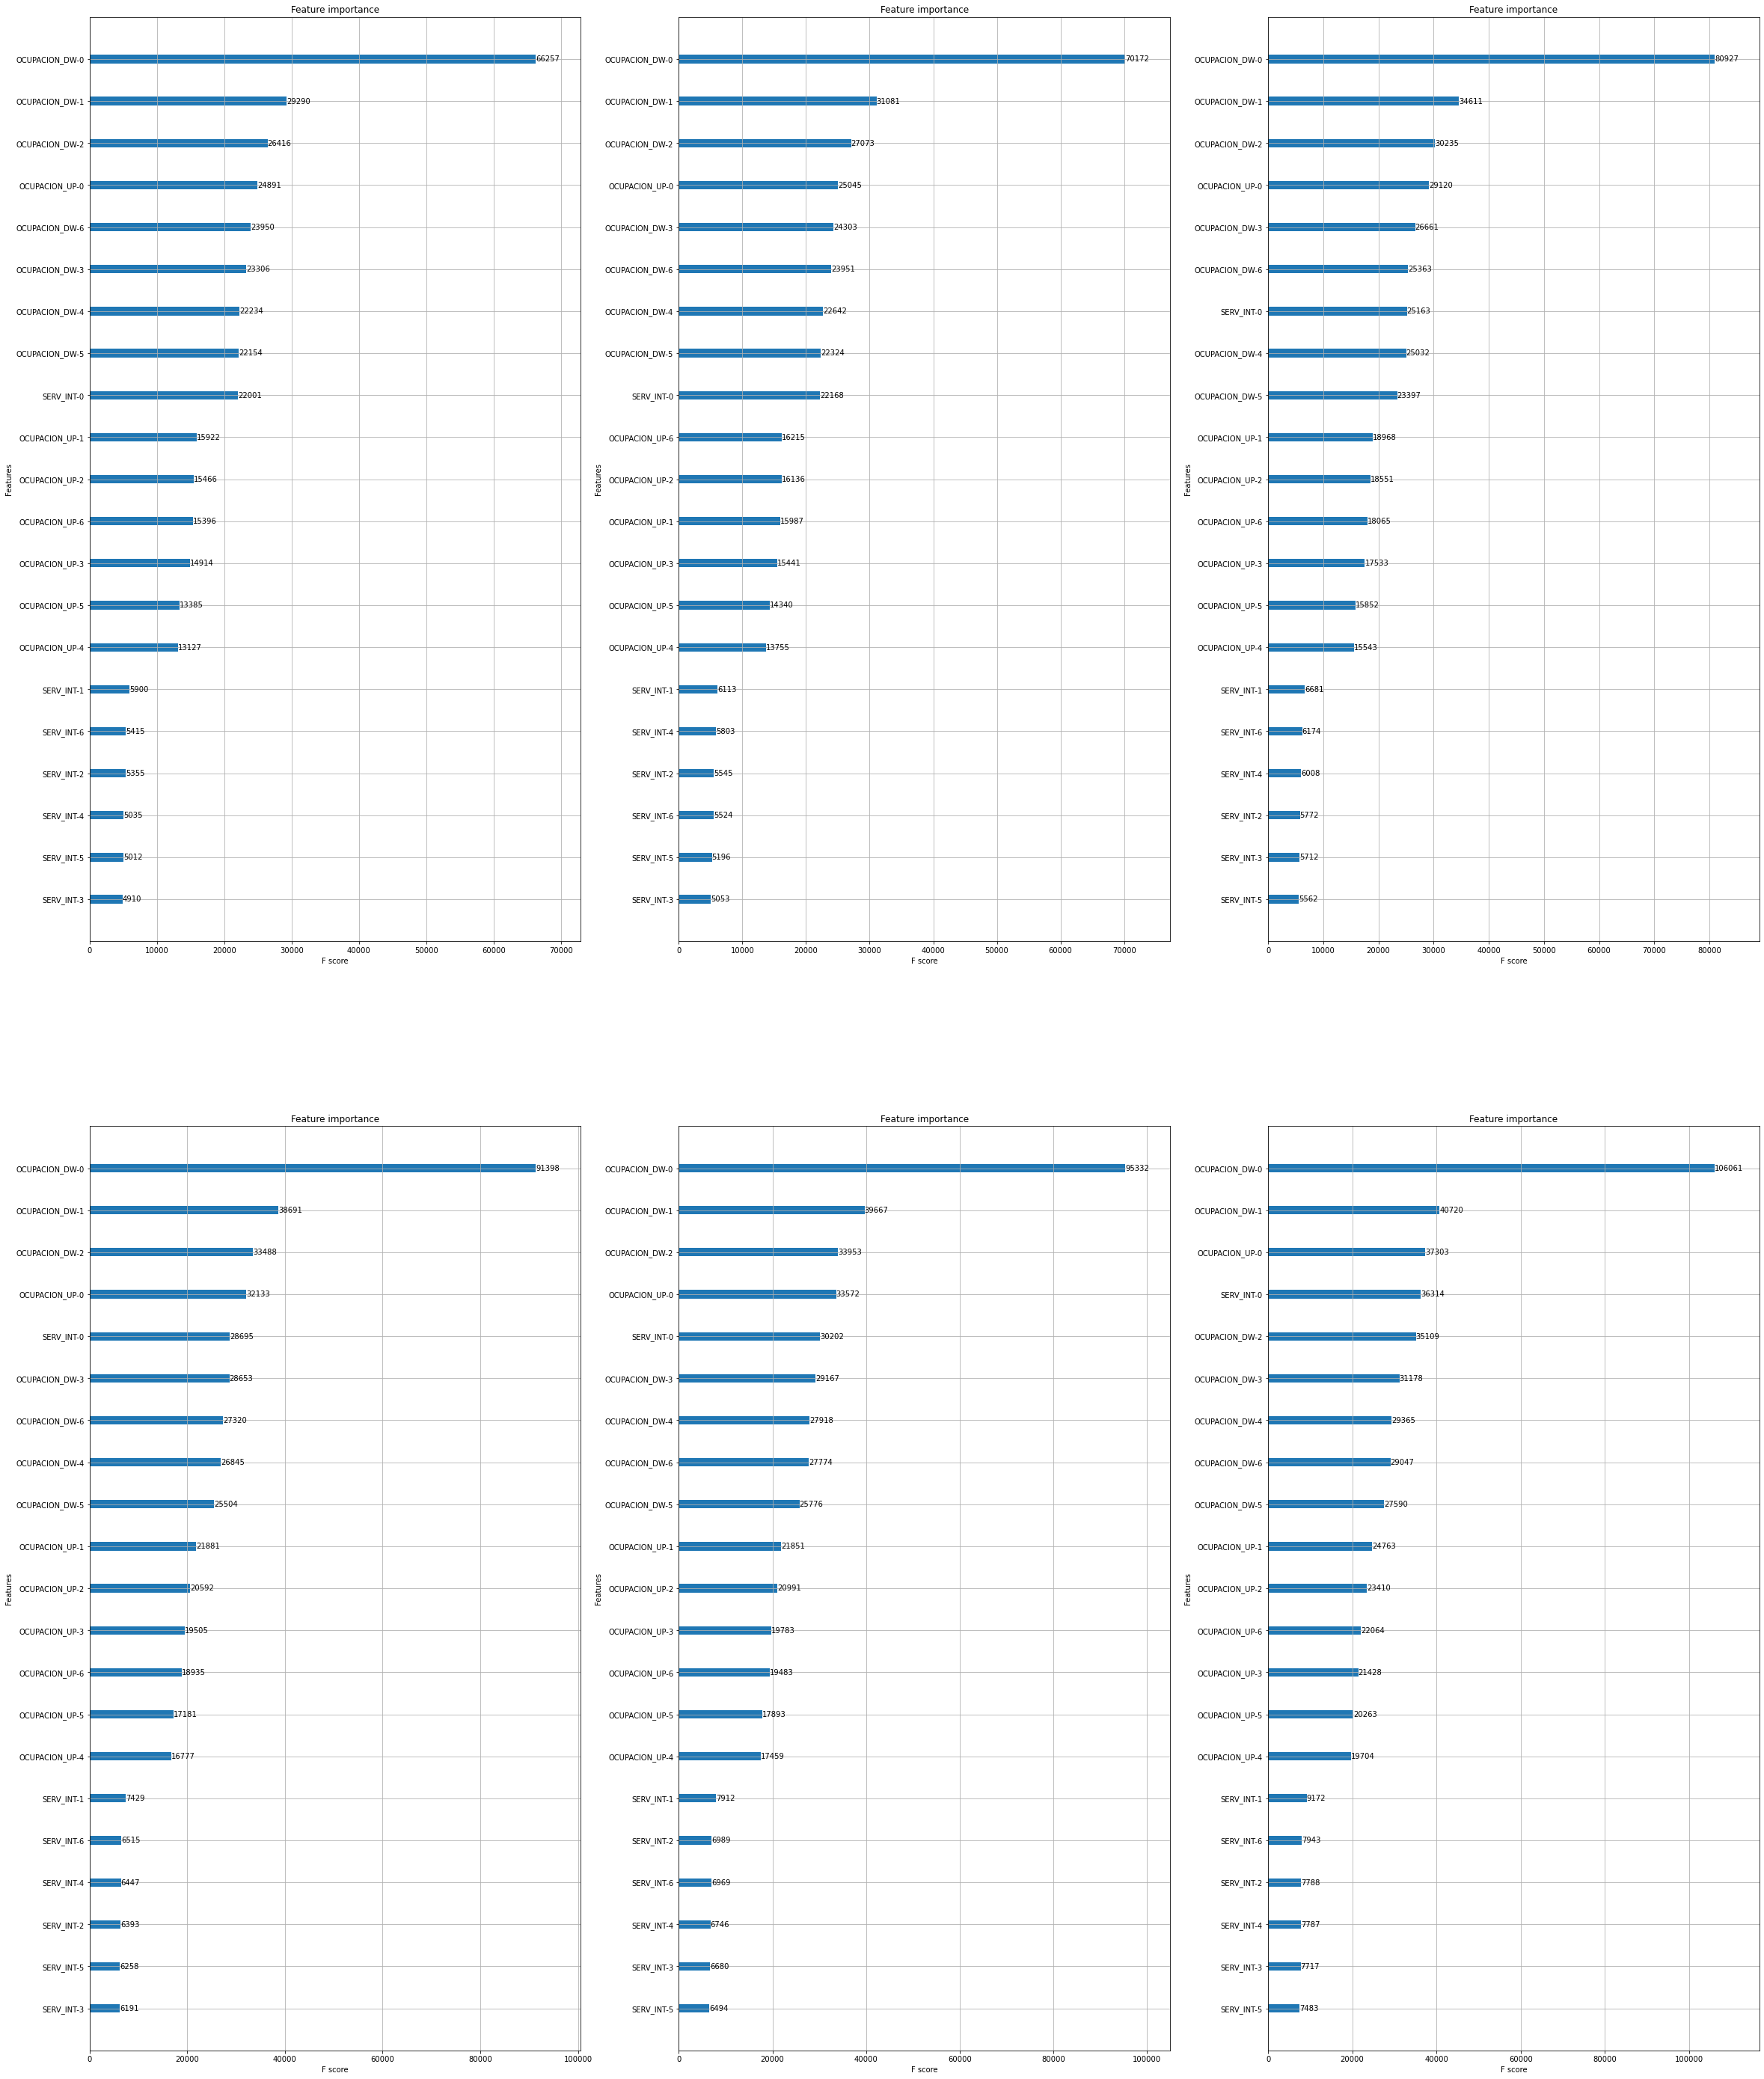

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(40,50))
i=0
for predVar in modelos:
    j=0    
    axes[i//3,i%3].set_title(predVar)    
    xgb.plot_importance(modelos[predVar]['modelo'],ax=axes[i//3,i%3]) 
    j=j+1
    i=i+1

#### Matrices de confusión

##### Semaforo

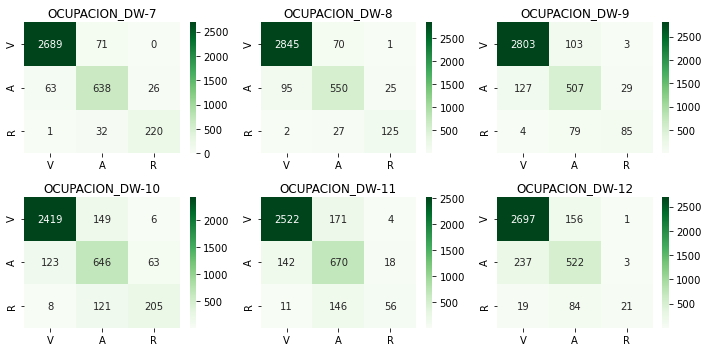

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:
    y_test_sem = [semaforoVal(x) for x in y_test[predVar]]    
    y_test_p_sem=[semaforoVal(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem, labels=['V','A','R'])
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Rojos

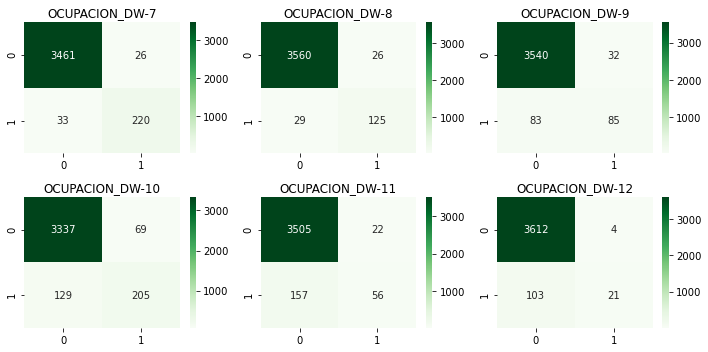

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelos:    
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Curva ROC y AUC

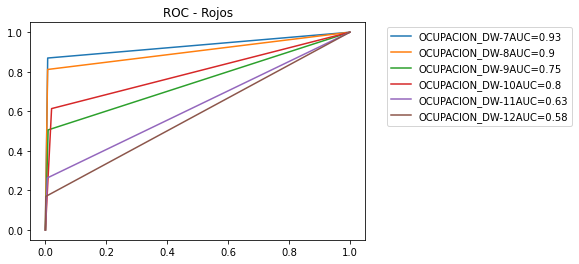

In [47]:
i=0
for predVar in modelos:
    j=0
    y_test_sem = [semaforoRojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))        
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Rojos");

##### ROC AMARILLOS

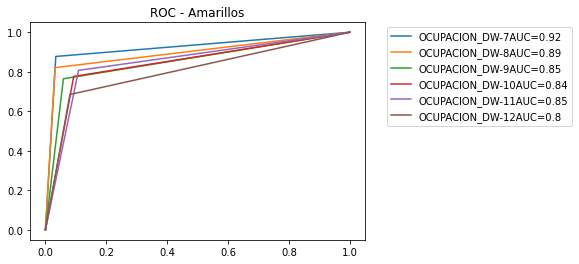

In [48]:
for predVar in modelos:        
    y_test_sem = [semaforoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos");

##### ROC Rojos y Amarillos

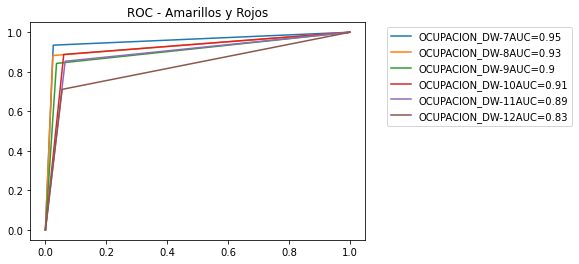

In [49]:
for predVar in modelos:    
    y_test_sem = [semaforoRojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoRojoAmarillo(x) for x in modelos[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelos[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'AUC={}'.format(np.round(auc1, 2)))           
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));
plt.title("ROC - Amarillos y Rojos");

### LGBMClassifier

#### Agregar Semaforo a variable y

In [50]:
X_train, X_test, y_train, y_test = train_test_split(XvarC, yvar, test_size = 0.3, random_state = 86, shuffle= True)

In [51]:
modelosClass={}
X_train_Balanceadas={}
for yCol in yColClass:  
    count=y_train[yCol].value_counts()
    n_samples=int(count.max())
    over_sampler = SMOTE(sampling_strategy=sampling_strategy(X_train, y_train[yCol],n_samples,t='minority'),k_neighbors=2)
    X_train_res, y_train_res= over_sampler.fit_resample(X_train,y_train[yCol])
    X_train_Balanceadas[yCol]=X_train_res
    
    print(yCol)
    y_test_aux=y_test[yCol]
    dicModelo={}        
    
    dicModelo['modelo']=LGBMClassifier(n_estimators=500, learning_rate=0.01, reg_alpha=1, reg_lambda=3, objective ='multiclass')
    dicModelo['modelo'].fit(X_train_res, y_train_res) # ajustamos los datos de entrenamiento

    dicModelo['predictions'] =dicModelo['modelo'].predict(X_test)
    dicModelo['explanation']=shap.TreeExplainer(dicModelo['modelo'])
    dicModelo['shap_values']=dicModelo['explanation'].shap_values(XvarC)    
    modelosClass[yCol]=dicModelo

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


 #### Variables Explicativas

#### Matrices de Confusión

##### Semaforo

OCUPACION_DW-7_sem2
exactitud: 0.9280748663101605
sensibilidad  0 :  0.9547101449275363
especificidad  0 :  0.939795918367347
sensibilidad  1 :  0.8294360385144429
especificidad  1 :  0.9522071025555924
sensibilidad  2 :  0.9209486166007905
especificidad  2 :  0.9810725552050473
OCUPACION_DW-8_sem2
exactitud: 0.9227272727272727
sensibilidad  0 :  0.9540466392318244
especificidad  0 :  0.9077669902912622
sensibilidad  1 :  0.7970149253731343
especificidad  1 :  0.952442996742671
sensibilidad  2 :  0.8766233766233766
especificidad  2 :  0.9813162297824874
OCUPACION_DW-9_sem2
exactitud: 0.8748663101604278
sensibilidad  0 :  0.9243726366448951
especificidad  0 :  0.8700361010830325
sensibilidad  1 :  0.7043740573152338
especificidad  1 :  0.9174520636984076
sensibilidad  2 :  0.6904761904761905
especificidad  2 :  0.9703247480403135
OCUPACION_DW-10_sem2
exactitud: 0.8387700534759358
sensibilidad  0 :  0.8966588966588966
especificidad  0 :  0.8945111492281304
sensibilidad  1 :  0.7067307692

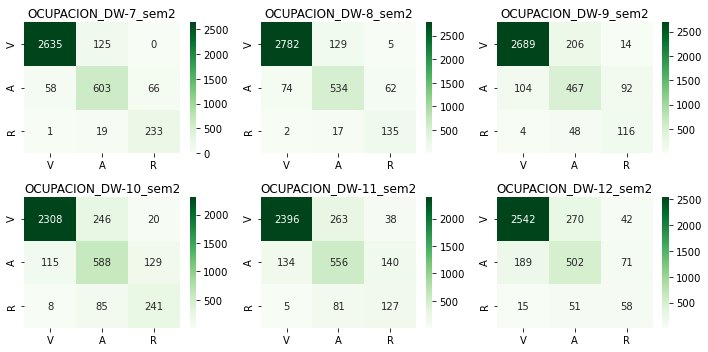

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,5))
i=0
for predVar in modelosClass:        
    y_test_sem = y_test[predVar]
    y_test_p_sem=modelosClass[predVar]['predictions']
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion, index=['V','A','R'], columns=['V','A','R'])
    print(predVar)
    medidasEvaluacion(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

##### Rojos

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


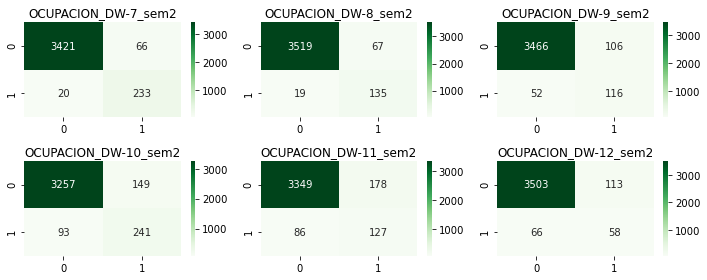

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(10,4))
i=0
for predVar in modelosClass:  
    print(predVar)
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    matrizConfucion = confusion_matrix(y_test_sem, y_test_p_sem)
    matrizConfucionDF=pd.DataFrame(matrizConfucion)
    sns.heatmap(matrizConfucionDF, annot = True, cmap = 'Greens', fmt='g', ax=axes[i//3,i%3])
    axes[i//3,i%3].set_title(predVar)    
    i=i+1
fig.tight_layout()

#####  Curva ROC

##### Solo Rojos

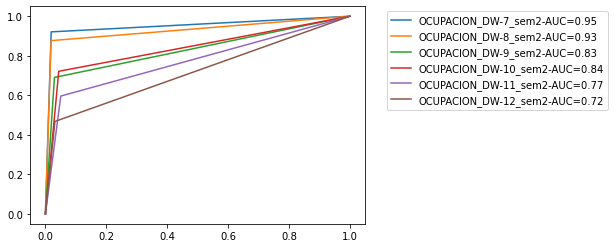

In [65]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Rojo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Rojo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Solo Amarillos

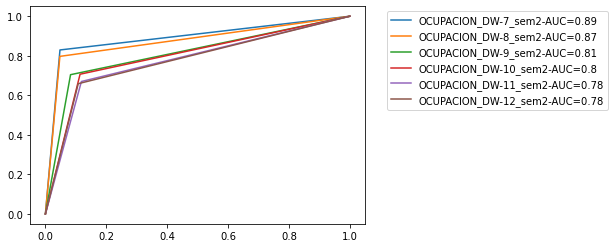

In [66]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2Amarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2Amarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

##### Rojos y amarillos

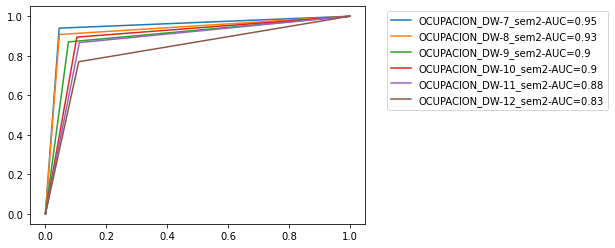

In [67]:
for predVar in modelosClass:        
    y_test_sem = [semaforoNum2RojoAmarillo(x) for x in y_test[predVar]]
    y_test_p_sem=[semaforoNum2RojoAmarillo(x) for x in modelosClass[predVar]['predictions']]
    fpr1, tpr1, _ = roc_curve(y_test_sem, y_test_p_sem)
    auc1 = roc_auc_score(y_test_sem, y_test_p_sem)
    modelosClass[predVar]['AUC']=auc1
    plt.plot(fpr1, tpr1, label = predVar+'-'+'AUC={}'.format(np.round(auc1, 2)))            
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1));

###  NUEVAS PREDICCIONES

In [68]:
data_ocupacionNp=data_ocupacion.copy()
data_ocupacionNpC=data_ocupacionC.copy()

In [69]:
periodos_x=6
fechaMaxima=data_ocupacionNp['FECHA'].max()
fechaInicialNp=fechaMaxima + relativedelta(months=-1*periodos_x)

In [70]:
data_ocupacionNp=data_ocupacionNp[data_ocupacionNp['FECHA']>=fechaInicialNp]
data_ocupacionNpC=data_ocupacionNpC[data_ocupacionNpC['FECHA']>=fechaInicialNp]
data_ocupacionNp['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNp['FECHA'])
data_ocupacionNpC['mesAnt']=(periodos_x)-diff_month(fechaMaxima,data_ocupacionNpC['FECHA'])

In [71]:
data_ocupacionNp['FECHA'].max()

Timestamp('2021-07-01 00:00:00')

In [72]:
data_ocupacionNp['FECHA'].min()

Timestamp('2021-01-01 00:00:00')

In [73]:
colsNp=data_ocupacionNp.columns
colsNp=colsNp[2:-1]
colsNpC=data_ocupacionNpC.columns
colsNpC=colsNpC[2:-1]

In [74]:
#Tabla para regresión
cols_xNp=[]
for i, col in enumerate(colsNp):
    tablaAnalisisNp = pd.pivot_table(data_ocupacionNp.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNp.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNp.columns}, inplace=True)    
    cols_xNp=cols_xNp+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNp = tablaAnalisisNp
    else:
        tablaAnalisisTotalNp = tablaAnalisisTotalNp.merge(tablaAnalisisNp, how='outer', on='COD_NODO')

In [75]:
#Tabla para clasificación
cols_xNpC=[]
for i, col in enumerate(colsNpC):
    tablaAnalisisNpC = pd.pivot_table(data_ocupacionNpC.reset_index(), index='COD_NODO', columns='mesAnt', values=col)
    tablaAnalisisNpC.rename(columns={x: (col+"-"+str(x)) for x in tablaAnalisisNpC.columns}, inplace=True)    
    cols_xNpC=cols_xNpC+[(col+"-"+str(x)) for x in range(0,periodos_x+1)]    
    if i==0:
        tablaAnalisisTotalNpC = tablaAnalisisNpC
    else:
        tablaAnalisisTotalNpC = tablaAnalisisTotalNpC.merge(tablaAnalisisNpC, how='outer', on='COD_NODO')

In [76]:
tablaAnalisisTotalNp=tablaAnalisisTotalNp.dropna()
tablaAnalisisTotalNpC=tablaAnalisisTotalNpC.dropna()

In [77]:
tablaResultados=tablaAnalisisTotalNp.copy()

#### Resultados 

In [78]:
for predVar in modelos:
    print(predVar)
    tablaResultados[predVar+'_pR']=modelos[predVar]['modelo'].predict(tablaAnalisisTotalNp[cols_x])
    tablaResultados[predVar+'_pR_Sem']=tablaResultados[predVar+'_pR'].apply(semaforoVal)    

OCUPACION_DW-7
OCUPACION_DW-8
OCUPACION_DW-9
OCUPACION_DW-10
OCUPACION_DW-11
OCUPACION_DW-12


In [83]:
for predVar in modelosClass:
    print(predVar)
    tablaResultados[predVar+'_pC']=modelosClass[predVar]['modelo'].predict(tablaAnalisisTotalNpC[cols_xC])
    tablaResultados[predVar+'_pC']=tablaResultados[predVar+'_pC'].apply(semaforoNum2Val)    

OCUPACION_DW-7_sem2
OCUPACION_DW-8_sem2
OCUPACION_DW-9_sem2
OCUPACION_DW-10_sem2
OCUPACION_DW-11_sem2
OCUPACION_DW-12_sem2


In [84]:
import pandas as pd
pd.set_option('display.max_columns', None)
tablaResultados.head(10)

mesAnt,OCUPACION_DW-0,OCUPACION_DW-1,OCUPACION_DW-2,OCUPACION_DW-3,OCUPACION_DW-4,OCUPACION_DW-5,OCUPACION_DW-6,OCUPACION_UP-0,OCUPACION_UP-1,OCUPACION_UP-2,OCUPACION_UP-3,OCUPACION_UP-4,OCUPACION_UP-5,OCUPACION_UP-6,SERV_INT-0,SERV_INT-1,SERV_INT-2,SERV_INT-3,SERV_INT-4,SERV_INT-5,SERV_INT-6,OCUPACION_DW-7_pR,OCUPACION_DW-7_pR_Sem,OCUPACION_DW-8_pR,OCUPACION_DW-8_pR_Sem,OCUPACION_DW-9_pR,OCUPACION_DW-9_pR_Sem,OCUPACION_DW-10_pR,OCUPACION_DW-10_pR_Sem,OCUPACION_DW-11_pR,OCUPACION_DW-11_pR_Sem,OCUPACION_DW-12_pR,OCUPACION_DW-12_pR_Sem,OCUPACION_DW-7_sem2_pC,OCUPACION_DW-8_sem2_pC,OCUPACION_DW-9_sem2_pC,OCUPACION_DW-10_sem2_pC,OCUPACION_DW-11_sem2_pC,OCUPACION_DW-12_sem2_pC
COD_NODO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,28.0,24.0,24.0,26.0,26.0,25.0,24.0,0.373000,V,0.342128,V,0.377587,V,0.398850,V,0.429511,V,0.402187,V,V,V,V,V,V,V
01S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.278147,0.302325,0.298426,0.290753,0.339117,0.306406,0.269256,159.0,163.0,160.0,167.0,171.0,170.0,177.0,0.442048,V,0.432223,V,0.470374,V,0.526327,V,0.516793,V,0.535028,V,V,V,V,V,V,V
02J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,11.0,12.0,12.0,12.0,13.0,14.0,15.0,0.371358,V,0.344051,V,0.376142,V,0.401348,V,0.429674,V,0.416324,V,V,V,V,V,V,V
02S,0.395358,0.402865,0.347061,0.401564,0.373240,0.348979,0.432986,0.182169,0.201613,0.286283,0.300031,0.301526,0.243914,0.227977,135.0,135.0,138.0,146.0,148.0,144.0,148.0,0.432886,V,0.432994,V,0.467296,V,0.531377,V,0.519288,V,0.540635,V,V,V,V,V,V,V
03J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,32.0,31.0,32.0,32.0,32.0,32.0,30.0,0.373789,V,0.345234,V,0.377764,V,0.399739,V,0.432240,V,0.422675,V,V,V,V,V,V,V
04J,0.311891,0.292409,0.302408,0.363124,0.362382,0.337471,0.350570,0.156491,0.202359,0.216276,0.221213,0.211418,0.220097,0.233507,18.0,19.0,20.0,19.0,19.0,21.0,20.0,0.373029,V,0.343444,V,0.377028,V,0.399038,V,0.430894,V,0.418702,V,V,V,V,V,V,V
05J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,63.0,60.0,61.0,60.0,60.0,60.0,61.0,0.305647,V,0.311924,V,0.328728,V,0.367478,V,0.345222,V,0.329941,V,V,V,V,V,V,V
06J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,44.0,43.0,43.0,41.0,40.0,40.0,39.0,0.303420,V,0.311274,V,0.327659,V,0.364988,V,0.346533,V,0.331917,V,V,V,V,V,V,V
07J,0.273088,0.269397,0.283512,0.299967,0.302036,0.318871,0.289796,0.269176,0.392237,0.320807,0.306752,0.274566,0.257956,0.237106,44.0,44.0,46.0,48.0,49.0,45.0,47.0,0.303616,V,0.311828,V,0.327494,V,0.363735,V,0.344914,V,0.330025,V,V,V,V,V,V,V


####  Ranking de Nodos

In [85]:
reglasRank = [[0 , 0.2, 0.6],[0.2 , 0.4, 0.8],[0.6, 0.8, 1]]

In [86]:
def valRank(predR,predC):    
    return reglasRank[predR][predC]

In [87]:
for predVar in modelos:    
    tablaResultados[predVar+'v1']=tablaResultados[predVar+'_pR_Sem'].apply(semaforoVal2Num)
    tablaResultados[predVar+'v2']=tablaResultados[predVar+'_sem2_pC'].apply(semaforoVal2Num)    
    tablaResultados[predVar+'_Rank'] = tablaResultados.apply(lambda x: valRank(x[predVar+'v1'],x[predVar+'v2']), axis=1)    

In [88]:
## ordernar columnas
columnasResultados=[]
for predVar in modelos: 
    auxCol=[predVar+'_pR',predVar+'_pR_Sem',predVar+'_sem2_pC',predVar+'_Rank']
    columnasResultados=columnasResultados+auxCol

In [89]:
#tablaResultados[columnasResultados]

In [90]:
tablaResultados[columnasResultados].to_csv('Resultados/resultadosVp.csv', index=True,sep=';')

In [94]:
end = datetime.now()
print(f'Tiempo: {end - start} segundos')

Tiempo: 0:24:11.551156 segundos


### Guardar Modelos

In [98]:
gModeloR={}
for yCol in cols_y:
    gModeloR[yCol]=modelos[yCol]['modelo']

gModeloC={}
for yCol in yColClass:
    gModeloC[yCol]=modelosClass[yCol]['modelo']

In [17]:
ruta_modelo = f"../ModelosGenerados/modeloR.pkl"
dump(gModeloR, ruta_modelo)

['../ModelosGenerados/modeloRP.pkl']

In [100]:
ruta_modelo = f"../ModelosGenerados/modeloC.pkl"
dump(gModeloC, ruta_modelo)

['modeloC.pkl']

### Ajuste Umbrales

In [ ]:
TablaRx=['OCUPACION_DW-0','OCUPACION_DW-1','OCUPACION_DW-2','OCUPACION_DW-3','OCUPACION_DW-4','OCUPACION_DW-5','OCUPACION_DW-6','OCUPACION_DW-7_pR','OCUPACION_DW-8_pR','OCUPACION_DW-9_pR','OCUPACION_DW-10_pR','OCUPACION_DW-11_pR','OCUPACION_DW-12_pR']

In [ ]:
tablaUmbral=tablaResultados[TablaRx]
tablaUmbral.columns=[x for x in range(0,13)]
tablaUmbral

In [ ]:
pd.melt(tablaUmbral) 

In [ ]:
tablaHumbral2=pd.melt(tablaUmbral)

In [ ]:
tablaHumbral2['rojo']=np.where(tablaHumbral2['value'] >= 0.8,1,0)
tablaHumbral2['amarillo']=np.where((tablaHumbral2['value'] >= 0.6) & (tablaHumbral2['value'] < 0.8),1,0)
tablaHumbral2     

In [ ]:
tablaHumbralRojos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='rojo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralRojos['%_Rojos']=100*tablaHumbralRojos[1]/(tablaHumbralRojos[0]+tablaHumbralRojos[1])
tablaHumbralRojos
# aqui vemos los porcentajes de rojos en cada mes

###  Definición Umbral Rojos

In [ ]:
tablaHumbralRojos.loc[:6].describe()

In [ ]:
tablaHumbralRojos.loc[6:].describe()

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.008778)[['value']].plot()
# vemos la variacion del porcentaje de rojos

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.01971)[['value']].plot()

###  Definión umbral Amarillos

In [ ]:
tablaHumbralAmarillos=pd.pivot_table(tablaHumbral2.reset_index(), index='variable', columns='amarillo', values='index', aggfunc=lambda x:len(x.unique()))
tablaHumbralAmarillos['%_Amarilos']=100*tablaHumbralAmarillos[1]/(tablaHumbralAmarillos[0]+tablaHumbralAmarillos[1])
tablaHumbralAmarillos

In [ ]:
tablaHumbralAmarillos.loc[:6].describe()

In [ ]:
tablaHumbralAmarillos.loc[6:].describe()

In [ ]:
tablaHumbral2.groupby('variable').quantile(1-0.175)[['value']].loc[6:].describe()

In [ ]:
g=sns.catplot(y='value', x='variable', palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

In [ ]:
g=sns.catplot(y='value', x='variable', kind="violin", palette="dark", data=pd.melt(tablaUmbral))
g.fig.set_size_inches(15,8)

In [ ]:
tablaResultados[TablaRx].describe().T